In [20]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
sns.set(rc={'figure.figsize':(15.7,8.27)})

In [2]:
n_rep = 100
n_bins = 1000
n_nodes = 10
n_regions = 40
n_reads = 10000
PATH = '../../workflows/bp_detection_performance/results/'

In [3]:
gt_files = [PATH + str(n_nodes)+'nodes_'+str(n_regions)+'regions_'+str(n_reads) \
             +'reads_simdata_'+str(x)+'_effective_regions.txt' for x in range(0,n_rep)]
bps_files = [PATH + 'simdata_'+str(x)+'_all_bps_comparison.csv' for x in range(0,n_rep)]
all_bins = range(0,n_bins)

In [4]:
all_bins

range(0, 1000)

In [5]:
all_tpr = []
all_fpr = []
all_bps_tables = []
for gt_file, bps_file in tqdm(zip(gt_files, bps_files)):
    bps = pd.read_csv(bps_file, header=None)
    bps.columns = ['idx','log_sp','stdev']
    bps['ranking'] = bps['log_sp'] / bps['stdev']
    # bps = bps.sort_values('ranking',ascending=False)
    bps = bps.dropna()
    
    all_bps_tables.append(bps)
    
    ground_truth = pd.read_csv(gt_file,header=None)
    ground_truth = ground_truth[0].values.tolist()
    
    for index, row in bps.iterrows():
        idx_val = bps.ix[index, 'idx']
        for gt in ground_truth:
            if (abs(idx_val - gt) <=2 and idx_val != gt):
                print('correcting ' + str(idx_val) + '->' + str(gt))
                bps.ix[index,'idx'] = gt
    
    
    threshold_coeffs = sorted(bps['ranking'].values)
    # Each breakpoint candidate has a different stdev value.
    # The ROC computations takes that into account.tpr_values = []
    tpr_values = []
    fpr_values = []
    for thr in threshold_coeffs:
        predicted_positives = []
        predicted_negatives = []
        for index, row in bps.iterrows():
            if row['ranking'] > thr:
                predicted_positives.append(row['idx'])
            else:
                break 
                
        #import ipdb; ipdb.set_trace()
        predicted_negatives = [i for i in all_bins if i not in predicted_positives]

        true_positives = [i for i in predicted_positives if i in ground_truth]
        false_positives = [i for i in predicted_positives if i not in ground_truth]

        true_negatives = [i for i in predicted_negatives if i not in ground_truth]
        false_negatives = [i for i in predicted_negatives if i in ground_truth]

        # import ipdb; ipdb.set_trace()
        assert(len(ground_truth) == (len(true_positives) + len(false_negatives)))
        tpr = len(true_positives) / len(ground_truth) # len(ground_truth)
        fpr = len(false_positives) / (1000 - len(ground_truth)) # (len(false_positives) + len(true_negatives))
        tpr_values.append(tpr)
        fpr_values.append(fpr)
    
    all_tpr.append(tpr_values)
    all_fpr.append(fpr_values)

A Jupyter Widget

/Users/mtuncel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/mtuncel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


correcting 597->595
correcting 131->132
correcting 799->800
correcting 434->433
correcting 821->820
correcting 155->154
correcting 760->759
correcting 434->433
correcting 515->516
correcting 634->633
correcting 597->599
correcting 156->155
correcting 938->937
correcting 426->427
correcting 678->677
correcting 797->796
correcting 225->224
correcting 515->514
correcting 103->104
correcting 598->599
correcting 928->927
correcting 366->364
correcting 171->170
correcting 752->751
correcting 121->119
correcting 579->581
correcting 185->186
correcting 156->157
correcting 377->376
correcting 760->758
correcting 261->263
correcting 106->105
correcting 501->500
correcting 682->684
correcting 356->355
correcting 572->573
correcting 390->389
correcting 659->658
correcting 335->334
correcting 142->143
correcting 248->247
correcting 641->640
correcting 290->291
correcting 859->858
correcting 985->983
correcting 882->883
correcting 970->968
correcting 698->697
correcting 343->342
correcting 301->300


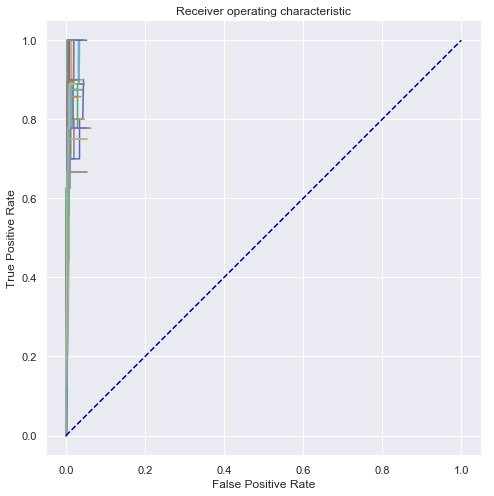

In [6]:
auc_vals = []
plt.figure(figsize=(8,8))
for tpr_values, fpr_values in zip(all_tpr, all_fpr):
    roc_auc = auc(fpr_values, tpr_values)
    auc_vals.append(roc_auc)
    plt.plot(fpr_values, tpr_values) # label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
plt.show()

In [8]:
threshold_indices = []
for idx, val in enumerate(all_tpr):
    df = pd.DataFrame(data=[all_tpr[idx],all_fpr[idx]]).T
    df.columns = ['tpr','fpr']
    df['idx'] = df.index
    df = df[df['tpr']==df['tpr'].max()]
    df = df[df['fpr']==df['fpr'].min()]
    print(df)
    thr_idx = df.idx.values[0]
    threshold_indices.append(thr_idx)

   tpr       fpr  idx
7  1.0  0.006048    7
     tpr      fpr  idx
28  0.75  0.00504   28
     tpr       fpr  idx
7  0.875  0.007056    7
    tpr       fpr  idx
21  0.9  0.006061   21
    tpr       fpr  idx
12  0.8  0.020202   12
13  0.8  0.020202   13
         tpr       fpr  idx
30  0.888889  0.007064   30
         tpr       fpr  idx
26  0.777778  0.006054   26
    tpr       fpr  idx
17  1.0  0.019173   17
    tpr       fpr  idx
34  0.9  0.008081   34
    tpr       fpr  idx
25  0.9  0.007071   25
         tpr       fpr  idx
21  0.857143  0.005035   21
      tpr      fpr  idx
13  0.875  0.00504   13
    tpr      fpr  idx
14  1.0  0.00504   14
         tpr       fpr  idx
15  0.777778  0.005045   15
         tpr       fpr  idx
32  0.888889  0.006054   32
   tpr      fpr  idx
4  1.0  0.01007    4
        tpr       fpr  idx
4  0.888889  0.006054    4
    tpr       fpr  idx
22  1.0  0.006061   22
         tpr       fpr  idx
21  0.888889  0.008073   21
        tpr       fpr  idx
2  0.857143 

In [9]:
len(threshold_indices)

100

In [10]:
len(all_tpr[0])

22

In [11]:
all_bps_tables[0].shape

(22, 4)

In [12]:
all_bps_tables[0]

,idx,log_sp,stdev,ranking
0,231,7.694570,0.579346,13.281476
1,264,5.121510,0.452308,11.323059
2,890,2.867880,0.335703,8.542908
3,921,2.350210,0.305240,7.699548
4,533,2.239630,0.271217,8.257705
5,551,1.828470,0.249098,7.340364
6,305,1.551020,0.225196,6.887423
7,486,1.238770,0.215350,5.752357
8,595,1.218840,0.207009,5.887860
9,320,0.939787,0.195679,4.802697


In [13]:
threshold_indices

[7,
 28,
 7,
 21,
 12,
 30,
 26,
 17,
 34,
 25,
 21,
 13,
 14,
 15,
 32,
 4,
 4,
 22,
 21,
 2,
 20,
 16,
 24,
 14,
 8,
 49,
 33,
 19,
 6,
 19,
 24,
 8,
 7,
 28,
 27,
 16,
 5,
 36,
 2,
 21,
 0,
 18,
 6,
 32,
 23,
 55,
 17,
 9,
 24,
 13,
 44,
 0,
 3,
 19,
 6,
 29,
 15,
 15,
 22,
 36,
 6,
 38,
 18,
 32,
 5,
 0,
 16,
 15,
 20,
 3,
 29,
 46,
 8,
 36,
 38,
 18,
 31,
 11,
 21,
 23,
 9,
 18,
 5,
 11,
 13,
 17,
 38,
 14,
 43,
 5,
 32,
 33,
 17,
 11,
 48,
 28,
 6,
 20,
 16,
 31]

In [14]:
bps_thresholds = []
for idx, val in enumerate(threshold_indices):
    bps_thresholds.append(all_bps_tables[idx].iloc[[val]]['ranking'].values[0])

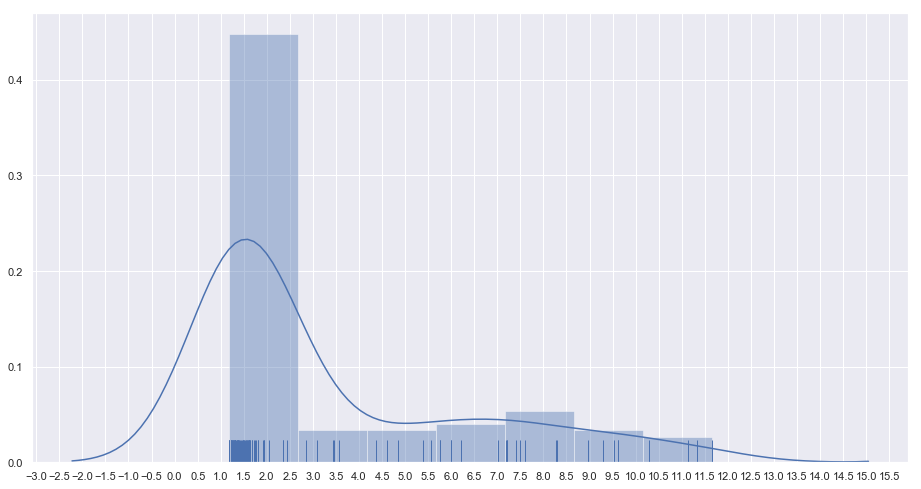

In [21]:
ax = sns.distplot(bps_thresholds, rug=True);
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))